Loading the processed ECG feature data
Successfully loaded 'all_records_features.csv'.
Dataset contains 109448 heartbeats.
Creating Feature Matrix (X) and Target Vector (y)
Missing values detected. Filling with column mean.
Feature Matrix (X) and Target Vector (y) created successfully.
Shape of Feature Matrix (X): (109448, 8)
Shape of Target Vector (y): (109448,)
Splitting Data into Training and Testing Sets
Data splitting complete.
Shape of X_train: (87558, 8)
Shape of X_test: (21890, 8)
Shape of y_train: (87558,)
Shape of y_test: (21890,)
Head of the Feature Matrix (X)
    rr_prev   rr_next  r_peak_amp  q_peak_amp  s_peak_amp      mean       std  \
0  0.791484  0.811111    1.258929   -0.193710   -0.154862  0.006115  0.188322   
1  0.811111  0.788889    1.216390   -0.215081   -0.190107  0.002328  0.171121   
2  0.788889  0.791667    1.134013   -0.273057   -0.195721  0.001890  0.162436   
3  0.791667  0.788889    1.100535   -0.211509   -0.193231 -0.003863  0.153559   
4  0.788889  0.81

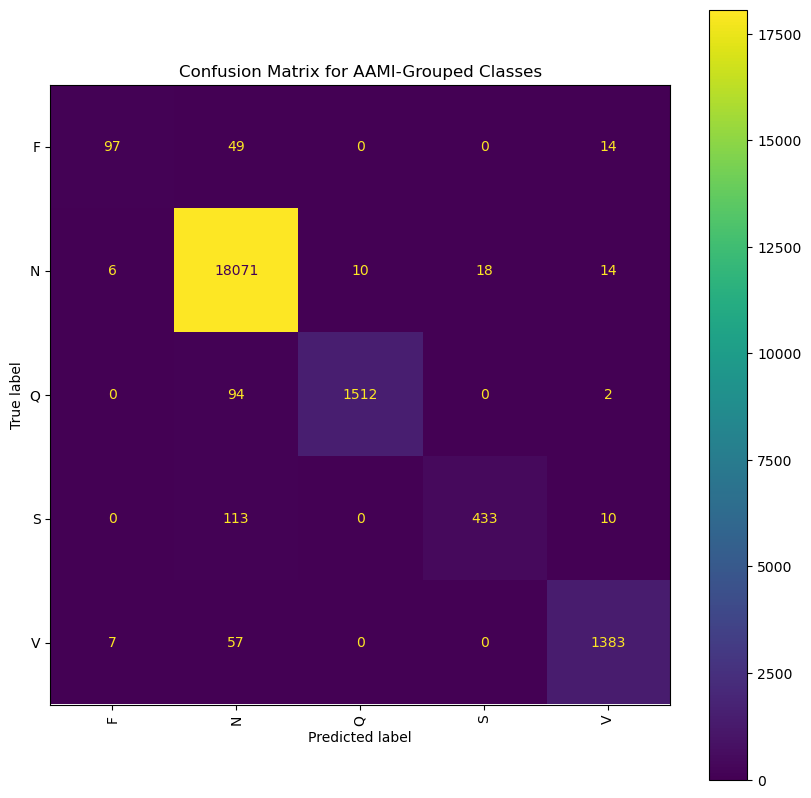

feature importances:


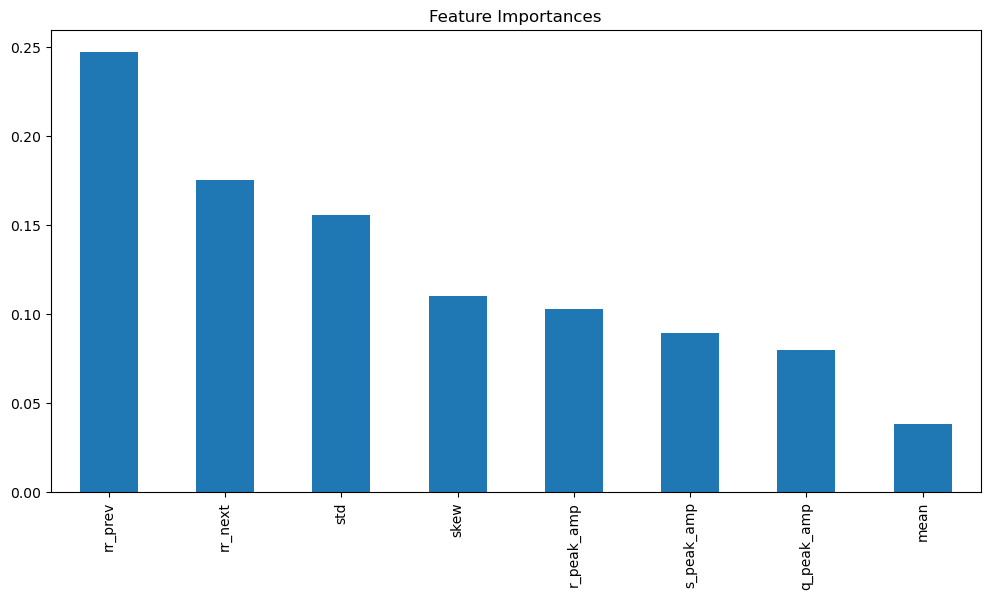

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("Loading the processed ECG feature data")
# Define processed dataset
filename = 'all_records_features.csv'

# Load the data into a pandas DataFrame
try:
    data_df = pd.read_csv(filename)
    print(f"Successfully loaded '{filename}'.")
    print(f"Dataset contains {len(data_df)} heartbeats.")
except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found.")
    print("Please make sure the CSV file is in the same directory as your notebook, or provide the full path.")
    # Exit or handle the error appropriately in a real script
    data_df = None

if data_df is not None:
    # Feature Matrix (X) and Target Vector (y) 
    print("Creating Feature Matrix (X) and Target Vector (y)")
    # The target vector 'y' is the 'label' column.
    y = data_df['label']
    # The feature matrix 'X' is all other columns.
    # As 'label' is the target, and 'record' because it's just an identifier.
    X = data_df.drop(columns=['label', 'record'])
    
    # Handle Missing Values
    """
    The rr_prev for the first beat and rr_next for the last beat of each record 
    are NaN (which will be filled with the mean of their respective columns).
    """
    if X.isnull().values.any():
        print("Missing values detected. Filling with column mean.")
        X.fillna(X.mean(), inplace=True)

    print("Feature Matrix (X) and Target Vector (y) created successfully.")
    print(f"Shape of Feature Matrix (X): {X.shape}")
    print(f"Shape of Target Vector (y): {y.shape}")

    # Split the Data into Training and Testing Sets 
    print("Splitting Data into Training and Testing Sets")
    """
    80% for training, 20% for testing.
    stratify=y ensures that the proportion of each class is the same
    in both the training and testing sets, which is crucial for imbalanced datasets.
    random_state ensures the split is reproducible.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("Data splitting complete.")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of y_test: {y_test.shape}")

    # To inspect the training data
    print("Head of the Feature Matrix (X)")
    print(X.head())

    print("Head of the Target Vector (y)")
    print(y.head())
    print("Head of the Training Data (X_train)")
    print(X_train.head())

# Defining label kapping for AAMI Standard 
print("Grouping Labels into AAMI Classes")

"""
N: Normal beats
S: Supraventricular Ectopic beats (SVEB)
V: Ventricular Ectopic beats (VEB)
F: Fusion beats
Q: Unknown beats
"""
aami_mapping = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q', '?': 'Q'
}

# Apply the mapping to your training and testing labels
# .get(label, 'Q') maps any unlisted symbols to the 'Q' class
y_train_mapped = y_train.map(lambda label: aami_mapping.get(label, 'Q'))
y_test_mapped = y_test.map(lambda label: aami_mapping.get(label, 'Q'))

print("Label grouping complete.")
print("\nValue counts in the MAPPED training set:")
print(y_train_mapped.value_counts())


# Initialise and train model on MAPPED Labels
print("Training the Random Forest Classifier on Grouped Labels")

# Initialise classifier with class_weight='balanced'
model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'
)

# Train the model on the training data with the mapped labels
model.fit(X_train, y_train_mapped)
print("Model training complete.")

#Make Predictions on the Test Set
print("Making Predictions on the Test Data")
y_pred_mapped = model.predict(X_test)


#Evaluate the Model's Performance
print("Evaluating Model Performance on Grouped Labels")

# Print a detailed classification report using the mapped test labels
print("Classification Report:")
print(classification_report(y_test_mapped, y_pred_mapped))


# Visualise the results with a Confusion Matrix
print("Displaying Confusion Matrix")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test_mapped, ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix for AAMI-Grouped Classes")
plt.show()

# Visualise feature importances
print("feature importances:")
importances = model.feature_importances_
feature_names = X.columns
pd.Series(importances, index=feature_names).sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Feature Importances')
plt.show()